In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn.model_selection
import torch.utils.data as data

In [2]:
#Extracting Data
companies = ["NVDA","MSFT","AAPL","GOOG"]
#Getting ticker object

data_standard = []
for c in companies:
    ticker = yf.Ticker(c)

    #Get historic data for the last 5 years
    history = ticker.history(start="2020-1-01",end="2024-1-01",actions=True)

    #Extract open,volume and dividends
    stock_data = history[["Open","Volume"]]

  

    #Convert to numpy
    data_standard_company = stock_data.to_numpy()

    #And concat it with the rest
    if(len(data_standard)>0):
        data_standard = np.concatenate((data_standard,data_standard_company),axis =1)
    else:
        data_standard = data_standard_company


print(data_standard)

[[5.94253877e+00 2.37536000e+08 1.51040826e+02 ... 1.35480400e+08
  6.66215830e+01 2.81320000e+07]
 [5.85168807e+00 2.05384000e+08 1.50603245e+02 ... 1.46322800e+08
  6.69349453e+01 2.37280000e+07]
 [5.78249330e+00 2.62636000e+08 1.49423674e+02 ... 1.18387200e+08
  6.70412161e+01 3.46460000e+07]
 ...
 [4.94861895e+01 2.33648000e+08 3.68889342e+02 ... 4.80877000e+07
  1.41859236e+02 1.72884000e+07]
 [4.96181225e+01 2.46587000e+08 3.70547702e+02 ... 3.40499000e+07
  1.40885912e+02 1.21925000e+07]
 [4.97880355e+01 3.89293000e+08 3.71169642e+02 ... 4.26721000e+07
  1.39723837e+02 1.48810000e+07]]


In [3]:
#Creating a dataset by taking the last n values
def create_dataset(dataset,lookback):
    X = []
    y=[]

    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback+1]
        X.append(feature)
        y.append(target)
    
    return torch.FloatTensor(X),torch.FloatTensor(y)

In [4]:
#Create dataset
lookback =30
X,y = create_dataset(data_standard,lookback)

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape)
print(y_train.shape)

torch.Size([780, 30, 8])
torch.Size([780, 8])


C:\Users\DELL\AppData\Local\Temp\ipykernel_8172\1101619413.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  return torch.FloatTensor(X),torch.FloatTensor(y)


In [5]:

class Trader(nn.Module):
    #Init
    def __init__(self,features:int,hidden_size:int,n_layers:int,mean,std):
        super().__init__()
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.mean = mean
        self.std = std


        #The lstms layers with dropout
        for i in range(n_layers):
            in_size =hidden_size
            
            if i ==0:
                in_size = features 

            self.lstm_layers.append(nn.LSTM(input_size=in_size,hidden_size=hidden_size,num_layers=1,batch_first=True))
            self.dropout_layers.append(nn.Dropout(0.2))
        
        #The fully connected model
        self.fc  = nn.Linear(hidden_size,features)       

    #The forward function
    def forward(self,x):
        for lstm,drop in zip(self.lstm_layers,self.dropout_layers):
            x = (x-self.mean)/(self.std)
            x,_ = lstm(x)
            x = drop(x)
        
        x = self.fc(x[:,-1,:])
        return x*self.std + self.mean

       

In [6]:
mean = X_train.mean(dim=(0, 1))
std = X_train.std(dim=(0, 1))
std[std == 0] = 1e-6

trader = Trader(X_train.shape[2], 128, 2, mean, std)
optimizer = optim.Adam(trader.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(X_train.shape)
print(y_train.shape)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
epochs = 200

torch.Size([780, 30, 8])
torch.Size([780, 8])


In [12]:
# ...existing code...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# re-instantiate trader from the updated Trader class so the instance uses the new forward/registered buffers
trader = Trader(X_train.shape[2], 128, 2, mean, std).to(device)

# recreate optimizer so it references the new model parameters
optimizer = optim.Adam(trader.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
epochs = 200

for e in range(epochs):
    trader.train()
    total_loss = 0.0
    total_samples = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        y_pred = trader(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = X_batch.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples if total_samples > 0 else float("nan")
    print(e, " Loss is", avg_loss)
# ...existing code...

0  Loss is 4049974852814648.5
1  Loss is 3554840396673339.0
2  Loss is 3407207939206727.0
3  Loss is 3321954680605480.5
4  Loss is 3258408707070025.5
5  Loss is 3166275402992256.5
6  Loss is 3132678922642962.5
7  Loss is 3042060795269477.0
8  Loss is 2973597603155317.0
9  Loss is 3127794326887566.0
10  Loss is 2992769667452613.0
11  Loss is 2773132864484567.5
12  Loss is 2848481835237124.0
13  Loss is 2741696118420359.0
14  Loss is 2604770001250902.5
15  Loss is 2614149252061425.5
16  Loss is 2435779504947788.0
17  Loss is 2343475108025769.5
18  Loss is 2408473508724484.0
19  Loss is 2294615180815354.5
20  Loss is 2240384453613641.5
21  Loss is 2009222631248733.2
22  Loss is 2035765142315638.2
23  Loss is 1955691889591784.2
24  Loss is 2064896583439785.2
25  Loss is 2369863975585508.5
26  Loss is 2013841430131003.0
27  Loss is 1767645613338098.8
28  Loss is 1863849679847760.0
29  Loss is 1696029237773296.2
30  Loss is 1838786463752150.0
31  Loss is 1581341474762226.8
32  Loss is 144100

In [13]:
#Generate a sequence
def generate_sequence(X,model,lookahead):
    generated = []
    model.eval()
    for i in range(lookahead):
        y = model(X.unsqueeze(0))
        X = torch.cat([X[1:,:],y],dim=0)
        

        #Numpy representation
        y_numpy = y.squeeze(0).detach().numpy()
        generated.append(y_numpy)
    return np.array(generated)

[214.45001 213.78787 212.2574 ]


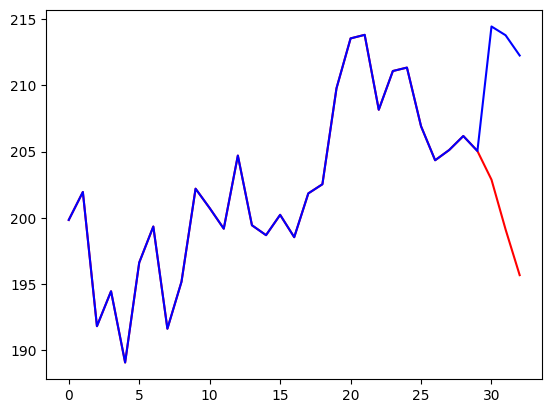

In [14]:
lookahead = 3
#Display sample graph
company_id = 1


index = 177

inp = X[index]

combined = inp[:,company_id*2].numpy()
actual = data_standard[index + lookback:index+lookback+lookahead,company_id*2]
generated = generate_sequence(inp,trader,lookahead)[:,company_id*2]
real = np.concatenate((combined,actual))
predicted = np.concatenate((combined,generated))

print(generated)
plt.plot(real,color='r')
plt.plot(predicted,color='b')

In [16]:
# ...existing code...
# Testing Simulation
# Simulating the market for training
money = 5000
stocks = [0,] * len(companies)

values = []
price_history = []

for x in X:
    # extract price feature tensor and convert to numpy
    price_indices = x[:, [2 * i for i in range(len(companies))]]
    price_indices_np = price_indices.cpu().numpy() if torch.is_tensor(price_indices) else np.array(price_indices)

    # get means/stds for the companies as numpy arrays
    means_np = mean[[2 * i for i in range(len(companies))]]
    stds_np = std[[2 * i for i in range(len(companies))]]
    means_np = means_np.cpu().numpy() if torch.is_tensor(means_np) else np.array(means_np)
    stds_np = stds_np.cpu().numpy() if torch.is_tensor(stds_np) else np.array(stds_np)

    # Actual last price
    prices = (price_indices_np * stds_np + means_np)[-1]

    # predictions (generate_sequence returns numpy) and pick price cols
    predictions = generate_sequence(x, trader, 3)[:, [2 * i for i in range(len(companies))]]
    predicted_indices = np.mean(predictions, axis=0)
    predicted = predicted_indices * stds_np + means_np
    changes = (predicted - prices) / prices

    contri = []
    div = 0
    # We sell all the stocks which are going down and calculate how much to reinvest
    for i in range(len(changes)):
        if changes[i] > 0:
            contri.append(changes[i])
            div += changes[i]
        else:
            money += stocks[i] * prices[i]
            stocks[i] = 0
            contri.append(0)

    if div != 0:
        spent = 0
        # Reinvest money
        for i in range(len(contri)):
            m = (contri[i] / div) * money
            new_stocks = (m // prices[i])
            stocks[i] += new_stocks
            spent += new_stocks * prices[i]
        money -= spent

    # Compute valuation
    val = money + np.multiply(stocks, prices).sum()
    values.append(val)

    price_history.append(prices)

print(val)
# ...existing code...

42760.859375


In [17]:
#Computing what would happen if we just invested and "forgot" about our holdings
forget_stocks = 5000/(price_history[0])
forgot_price= np.multiply(price_history,forget_stocks)


NVDA
MSFT
AAPL
GOOG


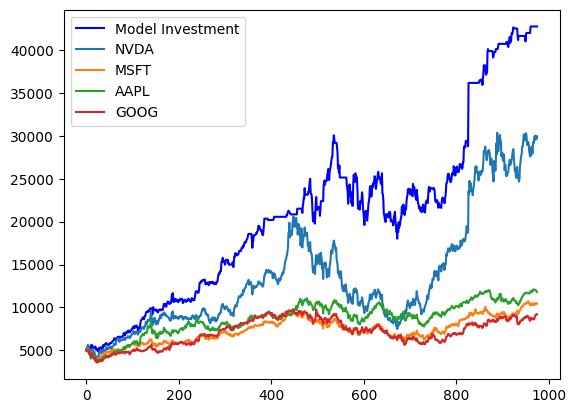

In [18]:
#Plot the graph of wealth
plt.plot(values,color='b',label="Model Investment")

 
#Plot for each company

for i in range(len(companies)):
    print(companies[i])
    plt.plot(forgot_price[:,i],label=companies[i])

plt.legend()

In [19]:
#NOW for testing data
#Extracting Data
companies = ["NVDA","MSFT","AAPL","GOOG"]
#Getting ticker object

data_standard_test = []
for c in companies:
    ticker = yf.Ticker(c)

    #Get historic data for the last 5 years
    history = ticker.history(start="2024-1-01",actions=True)

    #Extract open,volume and dividends
    stock_data = history[["Open","Volume"]]

  

    #Convert to numpy
    data_standard_company = stock_data.to_numpy()

    #And concat it with the rest
    if(len(data_standard_test)>0):
        data_standard_test = np.concatenate((data_standard_test,data_standard_company),axis =1)
    else:
        data_standard_test = data_standard_company

#Now we standardize the values
mean = data_standard_test.mean(axis=0)
std = data_standard_test.std(axis=0)
data_standard_test = (data_standard_test-mean)/(std)

print(data_standard_test)

[[-2.26910331  0.64482642 -1.50915465 ...  0.92597438 -1.42045771
  -0.13823517]
 [-2.32184698  0.06500681 -1.62042599 ...  0.0596141  -1.45813219
  -0.25571181]
 [-2.31339112 -0.02714651 -1.58234061 ...  0.54792645 -1.41103863
  -0.33288077]
 ...
 [ 1.74822241 -1.16929514  1.8736373  ...  1.21366593  3.00160236
  -0.81735417]
 [ 1.73802205 -1.19691675  1.94080409 ... -0.36210416  3.00236116
   0.69280286]
 [ 1.68852217 -0.95580117  2.02563427 ... -0.42477927  2.99325729
  -0.18593865]]


In [20]:
X_test,_ = create_dataset(data_standard_test,lookback)
print(X_test.shape)

torch.Size([423, 30, 8])


[102.394684 100.696335 105.33406 ]


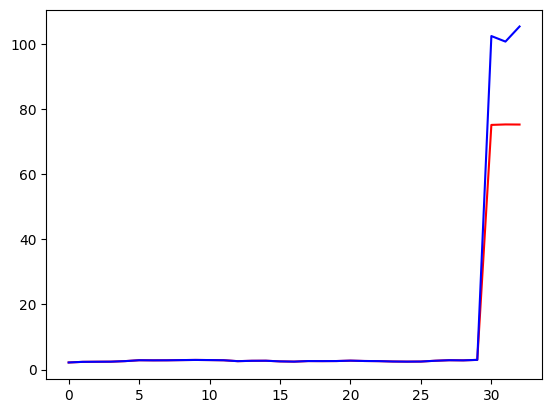

In [21]:
lookahead = 3
#Display sample graph
company_id = 3


index = -1

inp = X_test[index]

combined = inp[:,company_id*2].numpy()
actual = data_standard[index + lookback:index+lookback+lookahead,company_id*2]
generated = generate_sequence(inp,trader,lookahead)[:,company_id*2]
real = np.concatenate((combined,actual))
predicted = np.concatenate((combined,generated))

print(generated)

plt.plot(real,color='r')
plt.plot(predicted,color='b')

In [22]:
#Testing Simulation
#Simulating the market for training
money = 5000
stocks = [0,]*len(companies)

values = []

price_history = []

for x in X_test:
    price_indices = x[:,[2*i for i in range(0,len(companies))]]
    means = mean[[2*i for i in range(0,len(companies))]]
    stds = std[[2*i for i in range(0,len(companies))]]

    #Actual last price
    prices = (price_indices*stds+means).numpy()[-1]
    
    predictions = generate_sequence(x,trader,3)[:,[2*i for i in range(0,len(companies))]]
    predicted_indices = np.mean(predictions,axis=0)
    predicted = predicted_indices*stds+means
    changes = (predicted-prices)/prices
    

    contri  = [] 
    div = 0
    #We sell all the stocks which are going down and calculate how much to reinvest
    for i in range(len(changes)):
        #If there is a positive change
        if(changes[i]>0):
            contri.append(changes[i])
            div += changes[i]
        else:
            #Stock is going down... Sell it 
            money += stocks[i]*prices[i]
            stocks[i] = 0
            contri.append(0)

    if(div!=0):
        spent = 0
        #Reinvest money
        for i in range(len(contri)):
            #Money to invest
            m = (contri[i]/div)*money
            new_stocks = (m//prices[i])
            stocks[i] += new_stocks
            spent += new_stocks*prices[i]
        money -= spent
    
    #Compute valuation
    val = money + np.multiply(stocks,prices).sum()
    values.append(val)

    price_history.append(prices)

print(val)



C:\Users\DELL\AppData\Local\Temp\ipykernel_8172\3931601391.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prices = (price_indices*stds+means).numpy()[-1]


7899.4236070570205


In [23]:
#Computing what would happen if we just invested and "forgot" about our holdings
forget_stocks = 5000/(price_history[0])
forgot_price= np.multiply(price_history,forget_stocks)


NVDA
MSFT
AAPL
GOOG


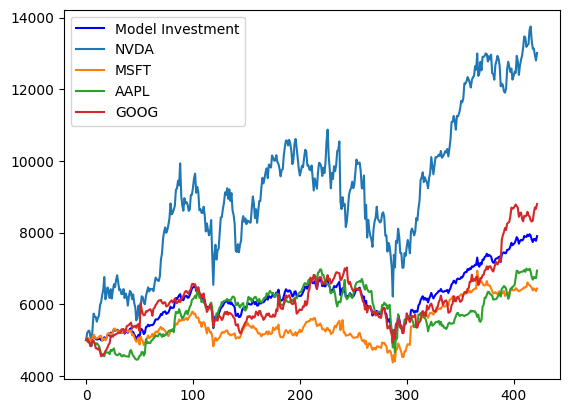

In [24]:
#Plot the graph of wealth
plt.plot(values,color='b',label="Model Investment")

 
#Plot for each company

for i in range(len(companies)):
    print(companies[i])
    plt.plot(forgot_price[:,i],label=companies[i])

plt.legend()

In [25]:
torch.save(trader.state_dict(),"Trader.pt")